In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd

In [2]:
from Channel_Modified import Static_Channel

In [3]:
class SBRNN(nn.Module):
    def __init__(self, input_shape, num_lstm1, num_lstm2, num_dense1, num_dense2, training=True):
        super(SBRNN,self).__init__()
        self.inp_shape = input_shape
        self.outp_shape = (input_shape[0], input_shape[1], num_dense2)
        
        self.num_lstm1 = num_lstm1
        self.num_lstm2 = num_lstm2
        self.num_dense1 = num_dense1
        self.num_dense2 = num_dense2
        self.training = training
        self.init_hidden()
        self.last_window = False
        
        if self.training==False:
            #counter for correct averaging
            self.init_counter()
            #memory to store results of past predictions
            self.memory = np.zeros((self.inp_shape[0],self.inp_shape[1],num_dense2))
        
        
        #defining the layers
        #input has shape (sequ_len, batch, num_features)
        self.lstm1 = nn.LSTM(self.inp_shape[2], self.num_lstm1 ,num_layers=1, bidirectional=True)
        self.concat1 = nn.Linear(self.num_lstm1*2, self.num_lstm1)       #*2 bidirectional
        self.lstm2 = nn.LSTM(self.num_lstm1, self.num_lstm2, num_layers=1, bidirectional=True)
        self.concat2 = nn.Linear(self.num_lstm2*2, self.num_lstm2)       #*2 bidirectional
        self.dense1 = nn.Linear(self.num_lstm2, self.num_dense1)
        self.dense2 = nn.Linear(self.num_dense1, self.num_dense2)    
    
    def init_hidden(self, hidden1=None, hidden2=None):
        if hidden1==None and hidden2==None:
            #tuple of 2 tensors because LSTMs have a second state, which must be initialized
            #2 in 1st dimension, because of bidirectional LSTMs
            #                                batch_size            
            self.hidden1 = (torch.randn(2, self.inp_shape[1], self.num_lstm1), 
                            torch.randn(2, self.inp_shape[1], self.num_lstm1))
        
            self.hidden2 = (torch.randn(2, self.inp_shape[1], self.num_lstm2), 
                            torch.randn(2, self.inp_shape[1], self.num_lstm2))
        #if the hidden state is passed between different windows
        else:
            self.hidden1 = hidden1
            self.hidden2 = hidden2
        
    def init_counter(self):
        self.counter = 1
        self.last_window = False
        
    def forward(self,x):
        x, self.hidden1 = self.lstm1(x, self.hidden1)
        x = F.relu(self.concat1(x))
        x, self.hidden2 = self.lstm2(x, self.hidden2)
        x = F.relu(self.concat2(x))
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        
        if self.training == True:
            return x
        else:
            x = F.softmax(x, dim=2)
            x = self._average_outputs(x)
        return x
    
    #to be only used without training, gradient is lost
    def _average_outputs(self,x):
        self.memory += x.detach().numpy()

        if self.last_window == False:
            x = torch.from_numpy(self.memory[0,:,:])/float(self.counter)
            #reshaping x to always have the same dimensions
            x = x.reshape(-1,self.outp_shape[1], self.outp_shape[2])
            #shift one element to the left and fill with zeros
            self.memory = np.roll(self.memory, -1, axis=0)
            self.memory[-1,:,:] = np.zeros((self.inp_shape[1],num_dense2))
            
            #to correctly normalize the outputs in the first window
            if self.counter < self.inp_shape[0]:
                self.counter += 1
            
            
        elif self.last_window == True:
            for i in range(len(self.memory[:,0,0])):
                self.memory[i,:,:] = self.memory[i,:,:]/self.counter

                
                if self.counter>1:
                    self.counter -= 1
            x = torch.from_numpy(self.memory)
        
        return x

In [4]:
#to assign the targets to class numbers
def target_correction(y_pred_batch):
    shape = y_pred_batch.shape
    y_pred_batch = np.argmax(y_pred_batch, axis=2)    
    y_pred_batch = y_pred_batch.reshape((shape[0],shape[1], 1))
    y_pred_batch[y_pred_batch==0] = -1
    return y_pred_batch

In [5]:
def digitize(sequence, high, low, bits):
    bins = np.linspace(low, high, 2**bits)
    for i in range(len(sequence)):
        bin_index = np.argmin(np.abs(bins-sequence[i]))
        sequence[i] = bins[bin_index]
    sequence = sequence/high
    
    return sequence

In [6]:
#defining the test parameters
load_path = "pytorch_model.pt"
oversampling_factor = 5
test_sequ_length = 1000
batch_size = 1

window_size = 50
num_lstm1 = 150
num_lstm2 = 110
num_dense1 = 80
num_dense2 = 2
num_epochs = 1

input_shape = (window_size, batch_size, oversampling_factor)
#the proposed propagation channel no. a
hc_a = [(0.1,0),(0.25,1),(0.16,2),(0.08,3),(0.04,4)]
#hc_test = [(1,0), (0.5,1)]

channel = Static_Channel(len(hc_a), hc_a, "rc", oversampling_factor)

sbrnn = SBRNN(input_shape, num_lstm1, num_lstm2, num_dense1, num_dense2, training=False)
sbrnn.load_state_dict(torch.load(load_path))
sbrnn.eval()

#to save SNR, bit error rates of SBRNN, Viterbi and Viterbi with Hamming distance
biterror_snr_list = [[],[]]
snr_range = [5, 10, 15, 20, 25, 30, 35]

for snr_db in snr_range:
    channel.set_snr(snr_db)
    
    transmit_seq = np.random.choice([-1,1],test_sequ_length)
    
    
    ############################## SBRNN Detection Part  ##################################
    
    #first transmission with T_s = 1 and Nyquist-signaling 
    channel.transmit(transmit_seq)
    
    received_seq = channel.receive()
    # 1-bit quantization
    received_seq = digitize(received_seq, sum([x[0] for x in hc_a]), -sum([x[0] for x in hc_a]), 1)
    
    #reshaping and type conversion for PyTorch
    received_seq = received_seq.reshape(test_sequ_length, batch_size, oversampling_factor)
    transmit_seq = transmit_seq.reshape(-1,batch_size,1)
    received_seq = received_seq.astype("float32")
    
    #creating an empty array
    sbrnn_prediction = np.zeros((test_sequ_length, batch_size, num_dense2))
    
    num_windows = test_sequ_length - window_size + 1
    #iterating over all windows, giving special treatment to the last window
    for i in range(num_windows-1):
        #prediction for 1 element per window
        sbrnn_prediction[i,:,:] = sbrnn(torch.from_numpy(received_seq[i:i+window_size,:,:]))
        
        hidden1_temp = (sbrnn.hidden1[0].detach(), sbrnn.hidden1[1].detach())
        hidden2_temp = (sbrnn.hidden2[0].detach(), sbrnn.hidden2[1].detach())
        sbrnn.init_hidden(hidden1_temp, hidden2_temp)
        
    #last window results in window_size predictions elements
    sbrnn.last_window = True
    sbrnn_prediction[-window_size:,:,:] = sbrnn(torch.from_numpy(received_seq[-window_size:,:,:]))
    #restart the counter and init the hidden state
    sbrnn.init_counter()
    sbrnn.init_hidden()
    
    #to transform the 0s and 1s to -1s and 1s
    sbrnn_prediction = target_correction(sbrnn_prediction)
    
    
    ############################  Calculating Bit Error Rates  ##############################
    
    num_bit_errors_net = np.count_nonzero(sbrnn_prediction-transmit_seq)
   
    
    bit_error_rate_net = num_bit_errors_net/float(test_sequ_length)
    
    biterror_snr_list[0].append(snr_db)
    biterror_snr_list[1].append(bit_error_rate_net)
    print("Testing SNR ",snr_db, " done" )
    
    
df = pd.DataFrame({"SNR": biterror_snr_list[0],
                   "Neuronales Netz": biterror_snr_list[1]})
df.to_csv("Testdaten.csv")
    


Testing SNR  5  done
Testing SNR  10  done
Testing SNR  15  done
Testing SNR  20  done
Testing SNR  25  done
Testing SNR  30  done
Testing SNR  35  done


In [7]:
import matplotlib.pyplot as plt

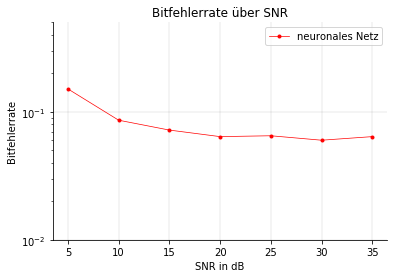

In [8]:
fig, ax = plt.subplots()
ax.set_title("Bitfehlerrate über SNR")
ax.set_ylabel("Bitfehlerrate")
ax.set_xlabel("SNR in dB")
ax.set_yscale("log")
ax.set_ylim((10**(-2), 5*10**(-1)))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.7)
ax.plot(np.array(biterror_snr_list[0]), np.array(biterror_snr_list[1]), label="neuronales Netz", marker='.', 
        linewidth=0.7, color='red')


plt.legend()
plt.savefig("PyTorch_model.pdf")
plt.show()

In [9]:
print(biterror_snr_list)

[[5, 10, 15, 20, 25, 30, 35], [0.151, 0.086, 0.072, 0.064, 0.065, 0.06, 0.064]]
